In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-pdg7xlyz
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-pdg7xlyz
  Created wheel for tensorflow-examples: filename=tensorflow_examples-55fcbdbe8578e7fa585c2a83d557cf759fa19d0f_-py3-none-any.whl size=270996 sha256=d30534e259d9c8706a4d2e08b490b093cb83eb41eb4d86c6e575c1b4d1bdcdbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6h931ly/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt

In [5]:
data, info = tfds.load('oxford_iiit_pet', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGINSFL/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGINSFL/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [34]:
for i in data["train"].take(1):
  print(i.keys())

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


In [35]:
# Input_image is the np array of image
# Input_mask are the labels of the image. Subtract 1 from it to get labels from [1,2,3] to [0,1,2]
def preprocess(datapoint):
  # Resize
  input_image, input_mask = datapoint["image"], datapoint["segmentation_mask"]
  input_image = tf.image.resize(input_image, (128, 128))
  input_mask = tf.image.resize(input_mask, (128, 128))

  input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalize
  input_mask -= 1   #Subtract to convert labels
  return input_image, input_mask

In [45]:
TRAIN_SIZE = info.splits['train'].num_examples
TEST_SIZE = info.splits['test'].num_examples

BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

In [47]:
train = data["train"].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = data["test"].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [55]:
# Create your state in __init__()  I.e Weights, bias, custom transformations, etc.
# Create your computation in call()
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    # Use the keras layer superclass
    super().__init__()
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [146]:
train_batch = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(tf.data.AUTOTUNE)

test_batch = test.batch(BATCH_SIZE)

In [87]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title = ["Input Image", "True Mask", "Predicted Mask"]

  # Can either be 2 (img+trueMask) or 3 (img+trueMask+predMask)
  for i in range(len(display_list)):
    # Entire Plot will have 1 row and len(display_list) columns
    # last argument is the index of the picture (Top left idx=0, index increases moving right; Bottom right idx=largest)
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

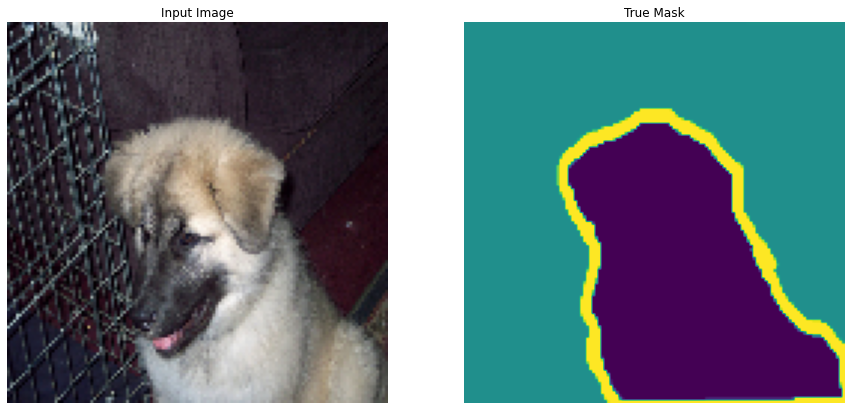

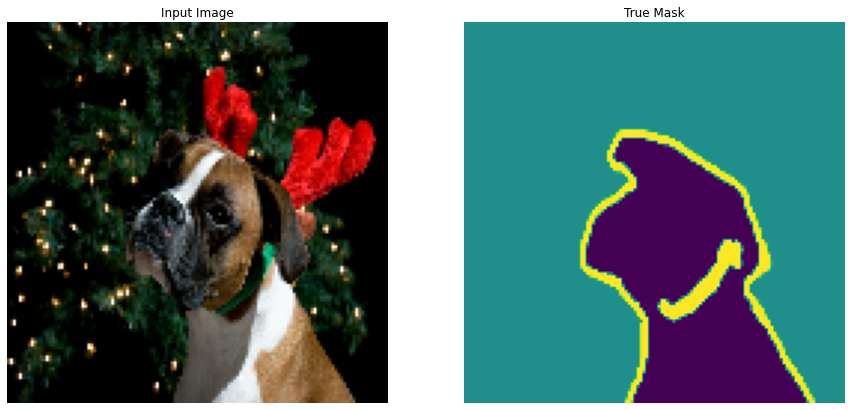

In [88]:
for images, masks in train_batch.take(2):
  img, mask = images[0], masks[0]
  display([img, mask])

## Define Model

We will use a Downsampler (MobileNet) and an Upsampler (Pix2pix)

In [108]:
downsampler = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

# For our downsampler, we will only use certain layers from the MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Get the layer attributes using get_layer (I.e This will return the shape, dtype, etc.)
downsampler_layers = [downsampler.get_layer(name).output for name in layer_names]

# Create the model, specifying that you want the output to be the specific mobilenetv2 layers
downsample_model = tf.keras.Model(inputs=downsampler.input, outputs=downsampler_layers)

# You don't want to train the mobilenetv2 weights
downsample_model.trainable = False

In [110]:
upsample_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [118]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=(128,128,3))

  # Downsample
  skips = downsample_model(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsample
  for up, skip in zip(upsample_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding="same")

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [119]:
OUTPUT_CLASSES = 3

# How inference works is that the channel with the highest value will be the label
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

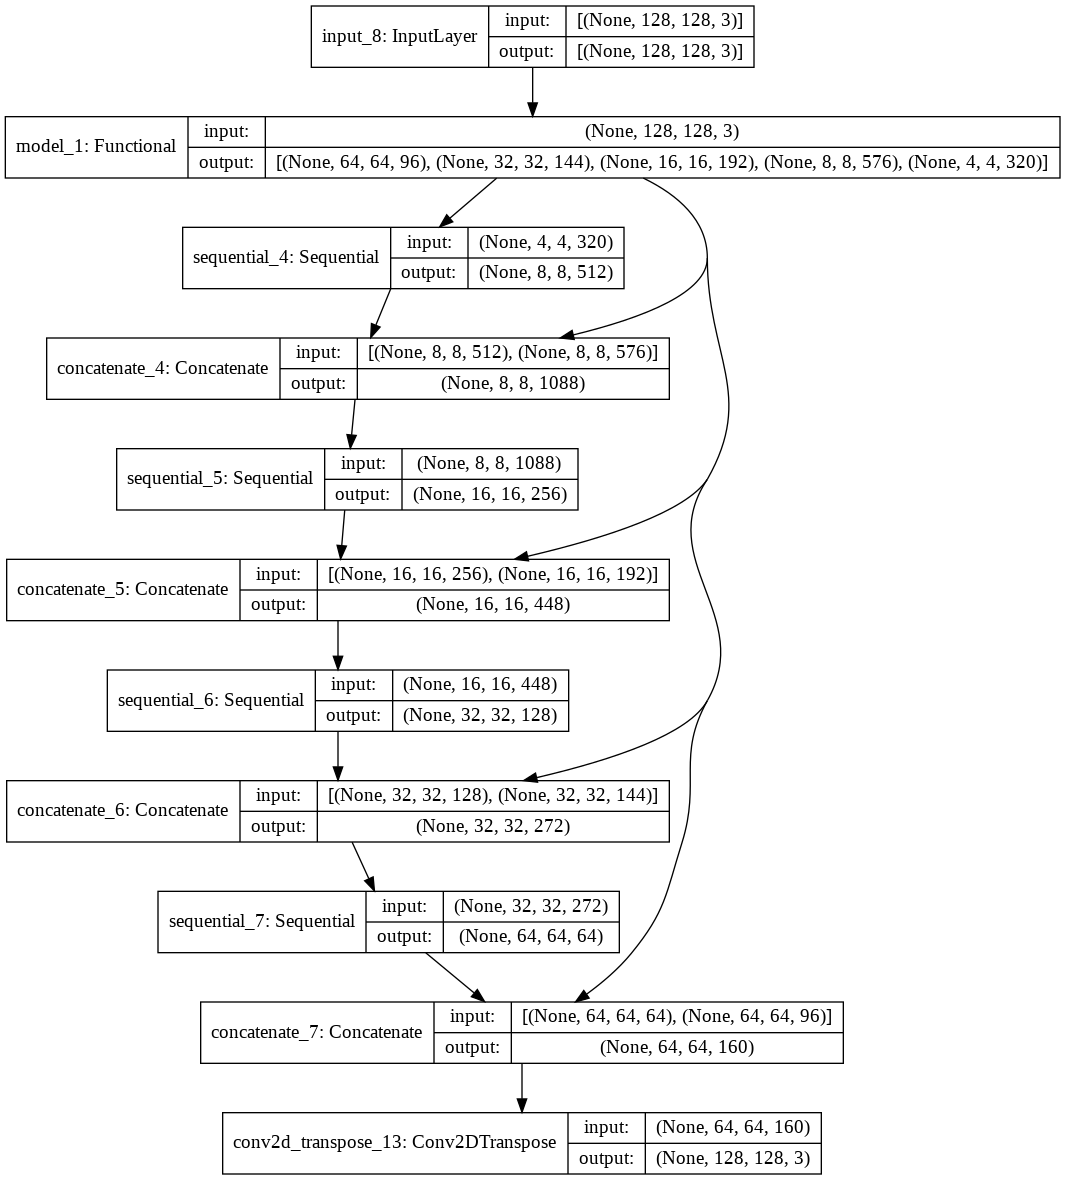

In [120]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [121]:
def create_mask(pred_mask):
  # Get the label by finding which channel is the largest
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [139]:
for images, masks in train_batch.take(1):
  sample_image, sample_mask = images[0], masks[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for img, true_mask in dataset.take(num):
      pred_mask = model.predict(img)
      pred_mask = create_mask(pred_mask)
      display([img[0], true_mask[0], pred_mask])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

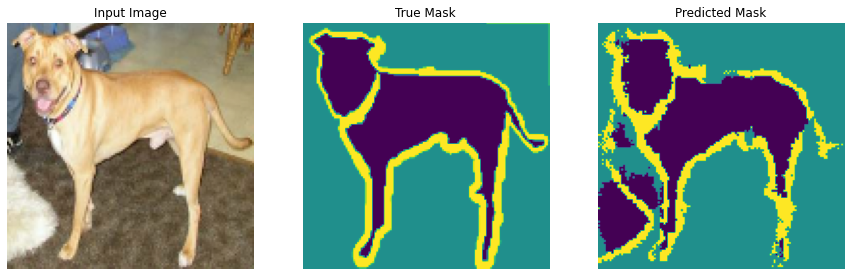

In [140]:
show_predictions()

In [141]:
# To clear the image output to show the next image (So images won't stack on each other)
from IPython.display import clear_output

class DisplayTrainingCB(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print(f'Sample prediction after epoch {epoch+1}')

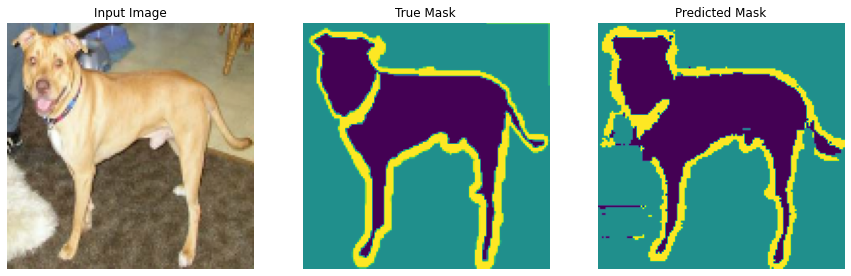

Sample prediction after epoch 20


In [147]:
# Further split the BATCH_SIZE (64) into 5 splits
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(train_batch, epochs=20, steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_batch,
                    callbacks=[DisplayTrainingCB()],
                    verbose=1)